[Vader Score Explanations](https://github.com/cjhutto/vaderSentiment)

The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

* positive sentiment: compound score >= 0.05
* neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
* negative sentiment: compound score <= -0.05


The pos, neu, and neg scores are ratios for proportions of text that fall in each category (so these should all add up to be 1... or close to it with float operation). These are the most useful metrics if you want multidimensional measures of sentiment for a given sentence.

[textblob](https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis)

The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

# Start Spark

In [1]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer    

ModuleNotFoundError: No module named 'vaderSentiment'

In [1]:
# note: you need to do the following:
# export PYSPARK_PYTHON=/home/jeroens/miniconda3/envs/pyspark/bin
# the direcotry of your pyspark kernel so that spark can hit the vader library in the udf

In [2]:
import pandas as pd


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, desc
from pyspark.sql.types import ArrayType, StringType, MapType, FloatType

In [4]:
spark = SparkSession.builder\
                        .master("local[*]")\
                        .config('spark.executor.memory', '5g')\
                        .config('spark.driver.memory', '5g')\
                        .config("spark.sql.session.timeZone", "UTC")\
                        .config("spark.sql.execution.arrow.enabled","true")\
                    .appName("Sentiment Analysis")\
                    .getOrCreate()
spark

In [5]:
# check time format
spark.sql("select from_unixtime(unix_timestamp(), 'z')").show()

+--------------------------------------------------------------------------+
|from_unixtime(unix_timestamp(current_timestamp(), yyyy-MM-dd HH:mm:ss), z)|
+--------------------------------------------------------------------------+
|                                                                       UTC|
+--------------------------------------------------------------------------+



# Twitter

## ETH

In [6]:
from pyspark.sql.functions import col


parquet_eth_path = "../data/tweets/ethereum/parquet/sentiment/"
eth = spark.read.parquet(parquet_eth_path)

In [7]:
eth.printSchema()

root
 |-- username: string (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- text: string (nullable = true)
 |-- retweets: integer (nullable = true)
 |-- favorites: integer (nullable = true)
 |-- geo: string (nullable = true)
 |-- mentions: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- id: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- pos_vader: float (nullable = true)
 |-- neg_vader: float (nullable = true)
 |-- neu_vader: float (nullable = true)
 |-- compound_vader: float (nullable = true)
 |-- polarity_textblob: float (nullable = true)
 |-- subjectivity_textblob: float (nullable = true)



In [8]:
#from pyspark.sql.functions import col
#test = eth.withColumn("datetime",col("datetime").cast("int")).limit(5).toPandas()

#test.datetime = pd.to_datetime(test.datetime,unit='s') 
#test

In [9]:
eth_summary = eth.select("datetime",
                        "retweets",
                         "favorites",
                         "pos_vader",
                         "neg_vader",
                         "neu_vader",
                         "compound_vader",
                         "polarity_textblob",
                         "subjectivity_textblob")\
                            .summary().toPandas()



In [10]:
eth_summary

,summary,retweets,favorites,pos_vader,neg_vader,neu_vader,compound_vader,polarity_textblob,subjectivity_textblob
0,count,4326320,4326320,4326193,4326193,4326193,4326193,4326193,4326193
1,mean,4.185458310989478,4.360915743634313,0.06594092441534928,0.019810879483277526,0.9142425385250046,0.12766594645681872,0.09602870237467225,0.2340603381160907
2,stddev,68.76365700629094,61.61669243516935,0.10842246666342376,0.05943834623232154,0.12085496006254005,0.3160192035238254,0.21948549527463967,0.29145384865587975
3,min,0,0,0.0,0.0,0.0,-0.9972,-1.0,0.0
4,25%,0,0,0.0,0.0,0.844,0.0,0.0,0.0
5,50%,0,0,0.0,0.0,1.0,0.0,0.0,0.0
6,75%,0,1,0.122,0.0,1.0,0.34,0.16666667,0.45625
7,max,19143,13843,1.0,1.0,1.0,0.9918,1.0,1.0


In [11]:
from pyspark.sql.functions import min, max, date_format

eth.withColumn('date',date_format('datetime','yyyy-MM-dd'))\
.select(min("date"),max("date")).show()

+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2015-12-31|2018-05-30|
+----------+----------+



### monthly breakdown

In [12]:
from pyspark.sql.functions import col,date_format,avg, col, count, when
daily_sentiment_avg = eth.withColumn('date',date_format('datetime','yyyy-MM-dd'))\
.groupby('date')\
.agg(
avg("pos_vader"),
avg("neg_vader"),
avg("neu_vader"),
avg("compound_vader"),
avg("polarity_textblob"),
avg("subjectivity_textblob"),
count(when(col("compound_vader") > 0.5, col("compound_vader"))).alias("negative"),
count(when(col("compound_vader") < -0.5, col("compound_vader"))).alias("positive"),
)\
.withColumn(
            "month",
            date_format('date','yyyy-MM')
            )\
.withColumn(
            "neg/pos ratio",
            col("negative")/col("positive")
            )\
.drop("negative","positive")

In [13]:
eth.withColumn(
            "month",
            date_format('datetime','yyyy-MM')
            )\
    .filter("month > '2017-06'")\
    .groupBy("month")\
    .count()\
    .sort("month")\
    .show()

+-------+------+
|  month| count|
+-------+------+
|2017-07|165121|
|2017-08|157272|
|2017-09|161144|
|2017-10|190493|
|2017-11|224647|
|2017-12|263108|
|2018-01|385561|
|2018-02|337175|
|2018-03|527780|
|2018-04|508056|
|2018-05|534220|
+-------+------+



In [14]:
# takes some time
from pyspark.sql.functions import desc, asc, lit, concat
eth_tweets_ss = eth.withColumn(
            "month",
            date_format('datetime','yyyy-MM')
            )\
    .filter("month > '2017-12'")\
    .withColumn("month",concat(col("month"),lit("-01")))\
    .select("month","pos_vader","neg_vader","neu_vader","compound_vader","polarity_textblob","subjectivity_textblob")\
    .toPandas()

In [15]:
import pandas as pd
eth_tweets_ss["month_date"] = pd.to_datetime(eth_tweets_ss.month)#.dt.date

In [22]:
eth_tweets_ss.head()

,month,pos_vader,neg_vader,neu_vader,compound_vader,polarity_textblob,subjectivity_textblob,month_date
0,2018-02-01,0.225,0.000,0.775,0.7003,0.375000,0.400000,2018-02-01
1,2018-02-01,0.000,0.000,1.000,0.0000,0.268182,0.650000,2018-02-01
2,2018-02-01,0.197,0.000,0.803,0.4019,0.500000,0.500000,2018-02-01
3,2018-02-01,0.112,0.135,0.753,-0.2732,0.055556,0.263889,2018-02-01
4,2018-02-01,0.174,0.000,0.826,0.2263,0.166667,0.166667,2018-02-01


In [16]:
eth_tweets_ss.dtypes

month                            object
pos_vader                       float32
neg_vader                       float32
neu_vader                       float32
compound_vader                  float32
polarity_textblob               float32
subjectivity_textblob           float32
month_date               datetime64[ns]
dtype: object

In [17]:
import seaborn as sns
%matplotlib inline

/home/jeroen/miniconda3/envs/udacity/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


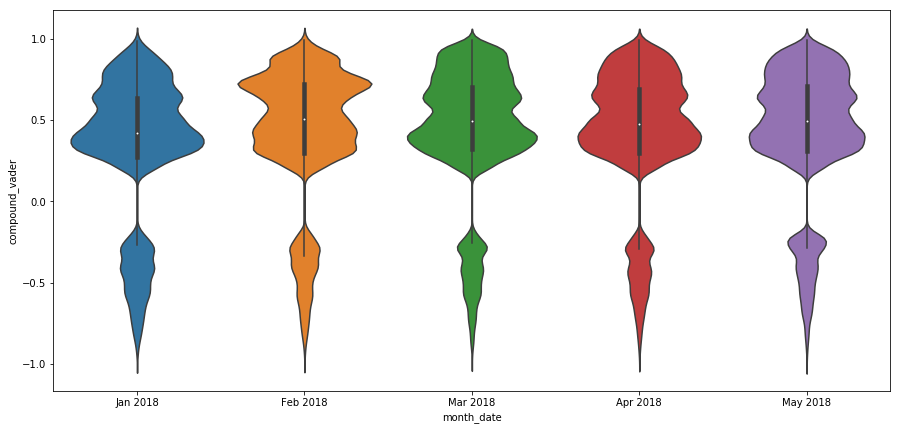

In [18]:
%matplotlib inline
## figure out the date stuff

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
ax = sns.violinplot(data=eth_tweets_ss[(eth_tweets_ss.compound_vader > 0.2) | (eth_tweets_ss.compound_vader < -0.2)].sort_values("month"),
                x="month_date",
                y="compound_vader",
                      )
#ax.xaxis_date()
#ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(
plt.FixedFormatter(eth_tweets_ss.sort_values("month").month_date.dt.strftime("%b %Y").unique())
)

In [ ]:
g = sns.FacetGrid(tips, col="sex", hue="smoker")
g.map(plt.scatter, "total_bill", "tip", alpha=.7)
g.add_legend();

/home/jeroen/miniconda3/envs/udacity/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


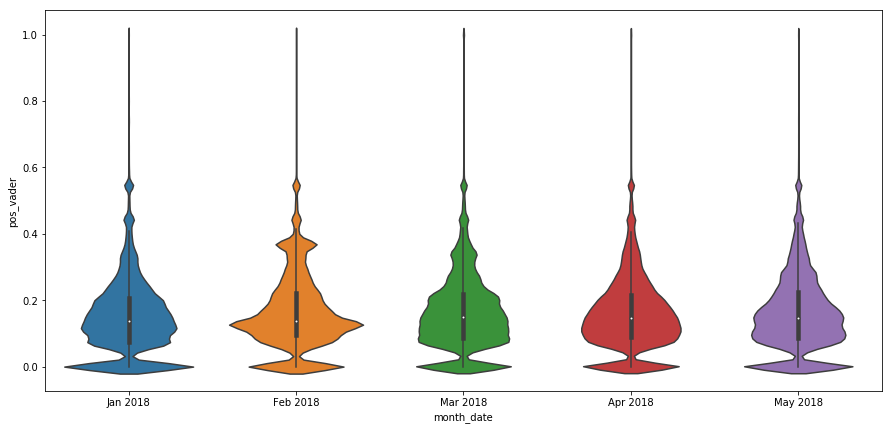

In [19]:

%matplotlib inline
## figure out the date stuff

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
ax = sns.violinplot(data=eth_tweets_ss[(eth_tweets_ss.compound_vader > 0.2) | (eth_tweets_ss.compound_vader < -0.2)].sort_values("month"),
                x="month_date",
                y="pos_vader",
                      )
#ax.xaxis_date()
#ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(
plt.FixedFormatter(eth_tweets_ss.sort_values("month").month_date.dt.strftime("%b %Y").unique())
)

/home/jeroen/miniconda3/envs/udacity/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


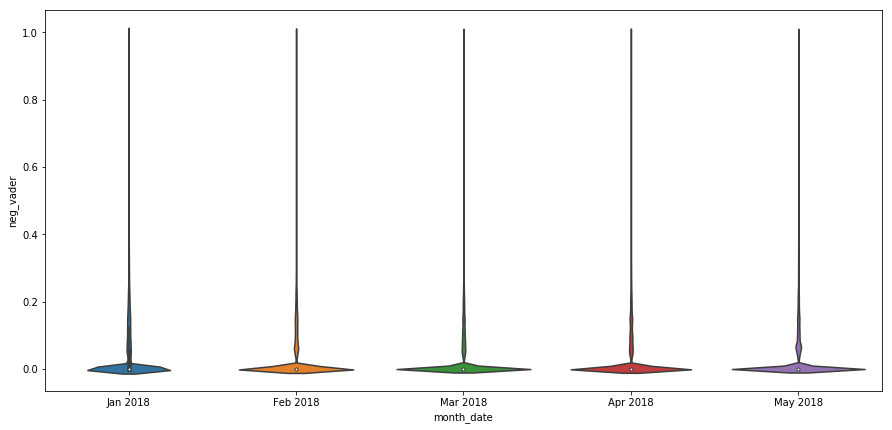

In [20]:

%matplotlib inline
## figure out the date stuff

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
ax = sns.violinplot(data=eth_tweets_ss[(eth_tweets_ss.compound_vader > 0.2) | (eth_tweets_ss.compound_vader < -0.2)].sort_values("month"),
                x="month_date",
                y="neg_vader",
                      )
#ax.xaxis_date()
#ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(
plt.FixedFormatter(eth_tweets_ss.sort_values("month").month_date.dt.strftime("%b %Y").unique())
)

/home/jeroen/miniconda3/envs/udacity/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


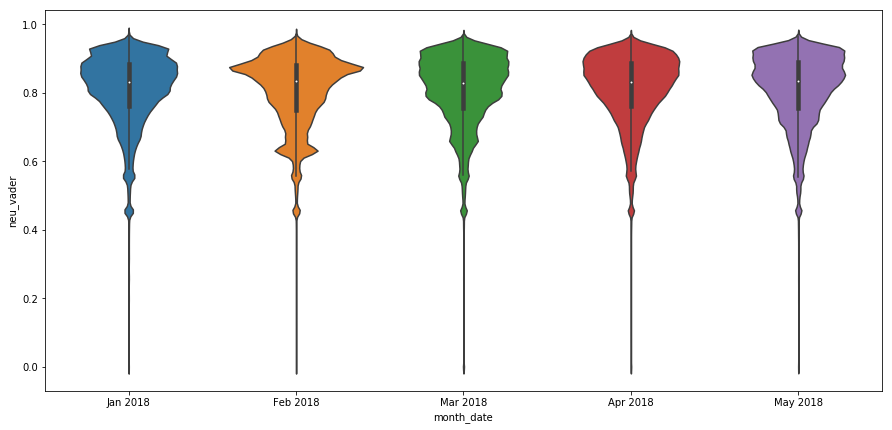

In [21]:
%matplotlib inline
## figure out the date stuff

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
ax = sns.violinplot(data=eth_tweets_ss[(eth_tweets_ss.compound_vader > 0.2) | (eth_tweets_ss.compound_vader < -0.2)].sort_values("month"),
                x="month_date",
                y="neu_vader",
                      )
#ax.xaxis_date()
#ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(
plt.FixedFormatter(eth_tweets_ss.sort_values("month").month_date.dt.strftime("%b %Y").unique())
)

/home/jeroen/miniconda3/envs/udacity/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


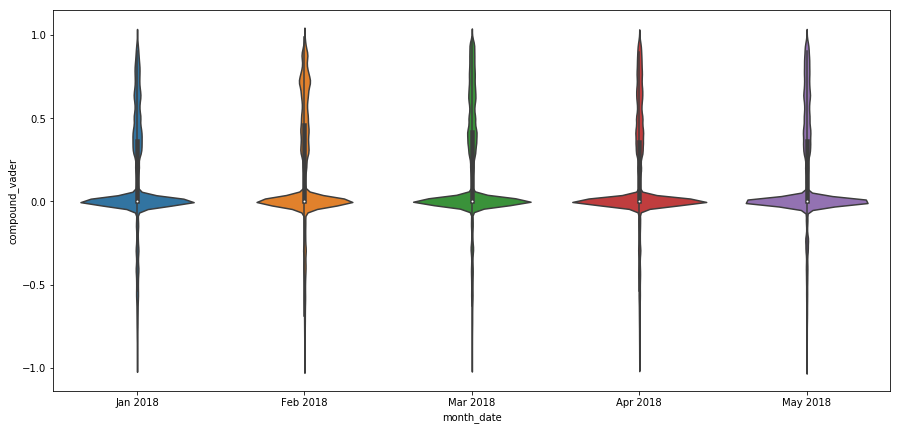

In [32]:
%matplotlib inline
## figure out the date stuff

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
ax = sns.violinplot(data=eth_tweets_ss.sort_values("month"),
                x="month_date",
                y="compound_vader",
                      )
#ax.xaxis_date()
#ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(
plt.FixedFormatter(eth_tweets_ss.sort_values("month").month_date.dt.strftime("%b %Y").unique())
)

In [106]:
eth_tweets_ss.head()

,month,pos_vader,neg_vader,neu_vader,compound_vader,polarity_textblob,subjectivity_textblob,month_date
0,2018-02-01,0.225,0.000,0.775,0.7003,0.375000,0.400000,2018-02-01
1,2018-02-01,0.000,0.000,1.000,0.0000,0.268182,0.650000,2018-02-01
2,2018-02-01,0.197,0.000,0.803,0.4019,0.500000,0.500000,2018-02-01
3,2018-02-01,0.112,0.135,0.753,-0.2732,0.055556,0.263889,2018-02-01
4,2018-02-01,0.174,0.000,0.826,0.2263,0.166667,0.166667,2018-02-01


### line plot

In [12]:
from pyspark.sql.functions import col,date_format,avg, col, count, when, unix_timestamp, from_unixtime

eth.withColumn('date',date_format('datetime','yyyy-MM-dd'))\
.limit(5).toPandas()

,username,datetime,text,retweets,favorites,geo,mentions,hashtags,id,permalink,pos_vader,neg_vader,neu_vader,compound_vader,polarity_textblob,subjectivity_textblob,date
0,Booleano101,2018-02-13 21:51:00,ethereum is better technology with more applic...,0,0,None,None,None,963561344476827648,https://twitter.com/Booleano101/status/9635613...,0.225,0.000,0.775,0.7003,0.375000,0.400000,2018-02-13
1,celilozturk24,2018-02-13 21:47:00,#Airdrop #live #Token #Ethereum #Giveaway #cry...,0,0,None,@cheche229 @I_Demonangel @maye5104,#Airdrop #live #Token #Ethereum #Giveaway #cry...,963560386392985600,https://twitter.com/celilozturk24/status/96356...,0.000,0.000,1.000,0.0000,0.268182,0.650000,2018-02-13
2,CryptoWiesiek,2018-02-13 21:45:00,Another interesting ICO on the line #TokenSale...,0,0,None,None,#TokenSale #Ethereum #LiveTreeADEPT #eth,963559738616184832,https://twitter.com/CryptoWiesiek/status/96355...,0.197,0.000,0.803,0.4019,0.500000,0.500000,2018-02-13
3,cointastical,2018-02-13 21:36:00,"Oh, definitely watching Ethereum Classic. Watc...",3,1,None,@cointastical @JulianHosp,None,963557469502017541,https://twitter.com/cointastical/status/963557...,0.112,0.135,0.753,-0.2732,0.055556,0.263889,2018-02-13
4,BitcoinInsight0,2018-02-13 21:33:00,Ethereum Classic Price Surprises Amid Turbulen...,0,0,None,None,None,963556811394691072,https://twitter.com/BitcoinInsight0/status/963...,0.174,0.000,0.826,0.2263,0.166667,0.166667,2018-02-13


In [13]:
daily_sentiment_avg = eth.withColumn('date',date_format('datetime','yyyy-MM-dd'))\
.withColumn("date_int",unix_timestamp('date', "yyyy-MM-dd"))\
.withColumn("date_int_2",from_unixtime('date_int'))\
.groupby('date',"date_int","date_int_2")\
.agg(
avg("pos_vader"),
avg("neg_vader"),
avg("neu_vader"),
avg("compound_vader"),
avg("polarity_textblob"),
avg("subjectivity_textblob"),
count(when(col("compound_vader") > 0.5, col("compound_vader"))).alias("negative"),
count(when(col("compound_vader") < -0.5, col("compound_vader"))).alias("positive"),
)\
.withColumn(
            "month",
            date_format('date','yyyy-MM')
            )\
.withColumn(
            "neg/pos ratio",
            col("negative")/col("positive")
            )\
.drop("negative","positive")

In [14]:
daily_sentiment_avg.printSchema()

root
 |-- date: string (nullable = true)
 |-- date_int: long (nullable = true)
 |-- date_int_2: string (nullable = true)
 |-- avg(pos_vader): double (nullable = true)
 |-- avg(neg_vader): double (nullable = true)
 |-- avg(neu_vader): double (nullable = true)
 |-- avg(compound_vader): double (nullable = true)
 |-- avg(polarity_textblob): double (nullable = true)
 |-- avg(subjectivity_textblob): double (nullable = true)
 |-- month: string (nullable = true)
 |-- neg/pos ratio: double (nullable = true)



In [15]:
daily_sentiment_avg.limit(5).toPandas()

,date,date_int,date_int_2,avg(pos_vader),avg(neg_vader),avg(neu_vader),avg(compound_vader),avg(polarity_textblob),avg(subjectivity_textblob),month,neg/pos ratio
0,2018-04-02,1522627200,2018-04-02 00:00:00,0.057790,0.019929,0.922278,0.137888,0.096119,0.241892,2018-04,10.735915
1,2018-02-17,1518825600,2018-02-17 00:00:00,0.077089,0.015098,0.907811,0.182483,0.141040,0.287178,2018-02,12.424710
2,2017-04-10,1491782400,2017-04-10 00:00:00,0.067328,0.017811,0.914864,0.107294,0.034917,0.177410,2017-04,4.851064
3,2017-06-16,1497571200,2017-06-16 00:00:00,0.065059,0.032473,0.902459,0.061954,0.068711,0.228318,2017-06,1.938326
4,2017-01-07,1483747200,2017-01-07 00:00:00,0.073901,0.012868,0.913232,0.144441,0.105696,0.265525,2017-01,10.533333


In [30]:
#daily_sentiment_avg.withColumn("x",unix_timestamp('date', "yyyy-MM-dd").cast("int")).limit(5).toPandas()

In [31]:
daily_sentiment_avg.printSchema()

root
 |-- date: string (nullable = true)
 |-- date_int: integer (nullable = true)
 |-- avg(pos_vader): double (nullable = true)
 |-- avg(neg_vader): double (nullable = true)
 |-- avg(neu_vader): double (nullable = true)
 |-- avg(compound_vader): double (nullable = true)
 |-- avg(polarity_textblob): double (nullable = true)
 |-- avg(subjectivity_textblob): double (nullable = true)
 |-- month: string (nullable = true)
 |-- neg/pos ratio: double (nullable = true)



In [22]:
daily_sentiment_avg.filter("month > '2017-12-30'")\
                    .groupBy("month").count().show()

+-------+-----+
|  month|count|
+-------+-----+
|2018-03|   31|
|2018-02|   28|
|2018-05|   30|
|2018-04|   30|
|2018-01|   31|
+-------+-----+



In [39]:
daility_sentiments = daily_sentiment_avg.withColumn(
                            "month",
                            date_format('date','yyyy-MM')
                                )\
                        .withColumn("month",col("month").cast("string"))\
                        .toPandas()
                        
    #                        .filter("month > '2017-10'")\

daility_sentiments["date_int"] = pd.to_datetime(daility_sentiments.date_int,unit='s',)             

In [44]:
daility_sentiments.head()

,date,date_int,date_int_2,avg(pos_vader),avg(neg_vader),avg(neu_vader),avg(compound_vader),avg(polarity_textblob),avg(subjectivity_textblob),month,neg/pos ratio
0,2018-04-02,2018-04-02,2018-04-02 00:00:00,0.057790,0.019929,0.922278,0.137888,0.096119,0.241892,2018-04,10.735915
1,2018-02-17,2018-02-17,2018-02-17 00:00:00,0.077089,0.015098,0.907811,0.182483,0.141040,0.287178,2018-02,12.424710
2,2017-04-10,2017-04-10,2017-04-10 00:00:00,0.067328,0.017811,0.914864,0.107294,0.034917,0.177410,2017-04,4.851064
3,2017-06-16,2017-06-16,2017-06-16 00:00:00,0.065059,0.032473,0.902459,0.061954,0.068711,0.228318,2017-06,1.938326
4,2017-01-07,2017-01-07,2017-01-07 00:00:00,0.073901,0.012868,0.913232,0.144441,0.105696,0.265525,2017-01,10.533333


In [60]:
import seaborn as sns

/home/jeroen/miniconda3/envs/udacity/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


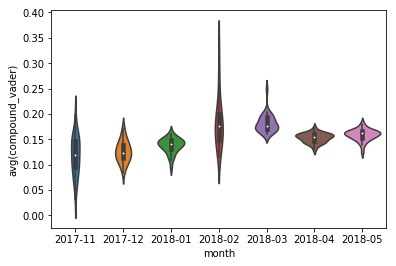

In [36]:
%matplotlib inline
sns.violinplot(data=daility_sentiments.sort_values("month"),
                x="month",
                y="avg(compound_vader)",
                      )

In [136]:
time = pd.Series(list(daility_sentiments.date_date))
daility_sentiments["date2"] = time

In [33]:
daility_sentiments.dtypes

date                           object
date_int                        int64
date_int_2                     object
avg(pos_vader)                float64
avg(neg_vader)                float64
avg(neu_vader)                float64
avg(compound_vader)           float64
avg(polarity_textblob)        float64
avg(subjectivity_textblob)    float64
month                          object
neg/pos ratio                 float64
dtype: object

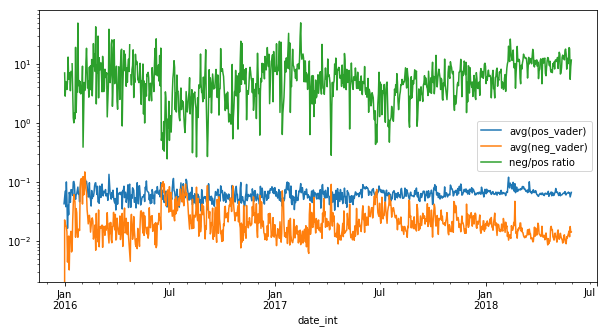

In [40]:
%matplotlib inline

ax = daility_sentiments[["avg(pos_vader)","avg(neg_vader)","neg/pos ratio","date_int"]]\
    .sort_values("date_int")\
    .set_index("date_int")\
    .plot(kind="line",logy=True,figsize=(10,5))


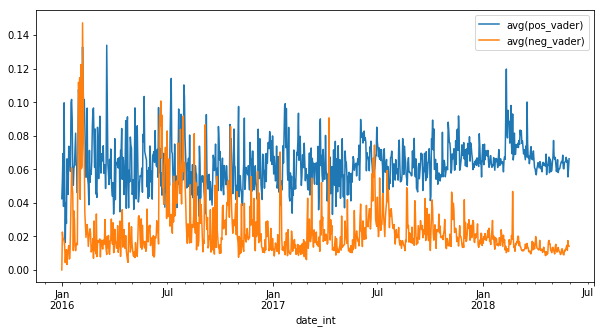

In [43]:
%matplotlib inline

ax = daility_sentiments[["avg(pos_vader)","avg(neg_vader)","date_int"]]\
    .sort_values("date_int")\
    .set_index("date_int")\
    .plot(kind="line",figsize=(10,5))


In [115]:
daility_sentiments.head()

,date,avg(pos_vader),avg(neg_vader),avg(neu_vader),avg(compound_vader),avg(polarity_textblob),avg(subjectivity_textblob),month,neg/pos ratio,month_date,date_date
0,2017-12-05,0.075455,0.027433,0.897113,0.147523,0.119876,0.314293,2017-12,8.582143,2017-12-01,2017-12-05
1,2017-05-14,0.051739,0.012456,0.935806,0.078751,0.094570,0.241260,2017-05,5.629630,2017-05-01,2017-05-14
2,2016-08-17,0.037389,0.082294,0.880321,-0.091171,0.117464,0.224371,2016-08,0.265176,2016-08-01,2016-08-17
3,2017-12-22,0.066456,0.027459,0.906084,0.106695,0.097764,0.239262,2017-12,2.918367,2017-12-01,2017-12-22
4,2017-10-20,0.054823,0.018778,0.926399,0.077656,0.067913,0.199230,2017-10,4.773913,2017-10-01,2017-10-20


In [96]:
ax.get_xticks()

array([-200.,    0.,  200.,  400.,  600.,  800., 1000.])

In [78]:
x = plt.FixedFormatter(daility_sentiments.sort_values("month").month.unique())

In [79]:
x.

In [50]:
np.arange(start, end, 2)

array([-0.75,  1.25,  3.25,  5.25,  7.25,  9.25, 11.25, 13.25, 15.25])

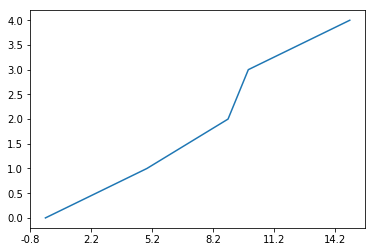

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

x = [0,5,9,10,15]
y = [0,1,2,3,4]
fig, ax = plt.subplots()
ax.plot(x,y)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 3))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.show()

In [ ]:
neutral = (col("compound_vader") >= -0.5) & ( col("compound_vader") <= 0.5 )

In [ ]:
from pyspark.sql.functions import sum, when, count
eth.withColumn(
            "month",
            date_format('datetime','yyyy-MM')
            )\
    .filter("month > '2017-06'")\
    .groupBy("month")\
    .agg(
        avg(when(col("compound_vader") > 0.5, col("compound_vader"))).alias("negative"),
        avg(when(col("compound_vader") < -0.5, col("compound_vader"))).alias("positive"),
        avg("compound_vader"),
        avg(when(neutral, col("compound_vader"))).alias("neurtral"),
        avg("pos_vader"),
        avg("neg_vader")
    )\
    .sort("month")\
    .show()

## BTC

In [6]:
parquet_eth_path = "../data/tweets/bitcoin/parquet/sentiment/"
btc = spark.read.parquet(parquet_eth_path)

In [13]:
btc_summary = btc.select("datetime",
                        "retweets",
                         "favorites",
                         "pos_vader",
                         "neg_vader",
                         "neu_vader",
                         "compound_vader",
                         "polarity_textblob",
                         "subjectivity_textblob")\
                            .summary().toPandas()

btc_summary

,summary,retweets,favorites,pos_vader,neg_vader,neu_vader,compound_vader,polarity_textblob,subjectivity_textblob
0,count,26208296,26208294,26205225,26205225,26205225,26205225,26205225,26205225
1,mean,1.302150052029327,2.1291564800059097,0.07022994321253641,0.03025854424040131,0.8994879080242302,0.09673881072100948,0.07393363473549305,0.2309396592474843
2,stddev,45.977790117796886,133.17901233216585,0.1144395079206362,0.07583117506971562,0.13237850713931992,0.32875733098281235,0.22197325711579075,0.29640478878080495
3,min,0,0,0.0,0.0,0.0,-0.9992,-1.0,0.0
4,25%,0,0,0.0,0.0,0.816,0.0,0.0,0.0
5,50%,0,0,0.0,0.0,1.0,0.0,0.0,0.0
6,75%,0,0,0.133,0.0,1.0,0.3182,0.13333334,0.45454547
7,max,69911,296278,1.0,1.0,1.0,0.9996,1.0,1.0


In [8]:
btc.count()

26208300

In [9]:
# takes some time
from pyspark.sql.functions import desc, asc, lit, concat, date_format, col
btc_tweets_ss = btc\
            .select("month","pos_vader","neg_vader","neu_vader","compound_vader","polarity_textblob","subjectivity_textblob","datetime")\
            .withColumn(
                "month",
                date_format('datetime','yyyy-MM')
            )\
            .drop("datetime")
            .filter("month > '2017-12'")\
            .withColumn("month",concat(col("month"),lit("-01")))\
            .toPandas()

In [12]:
btc_tweets_ss.head()

,month,pos_vader,neg_vader,neu_vader,compound_vader,polarity_textblob,subjectivity_textblob
0,2018-05-01,0.000,0.000,1.000,0.0000,0.000000,0.000000
1,2018-05-01,0.095,0.000,0.905,0.2960,0.000000,0.000000
2,2018-05-01,0.111,0.182,0.707,-0.3400,-0.200000,0.000000
3,2018-05-01,0.000,0.000,1.000,0.0000,0.000000,0.000000
4,2018-05-01,0.000,0.058,0.942,-0.2263,-0.035714,0.121429


In [7]:
from pyspark.sql.functions import col,date_format,sum
btc.withColumn('date',date_format('datetime','yyyy-MM-dd'))\
.groupby('date')\
.agg(
sum("pos_vader"),
sum("neg_vader"),
sum("neu_vader"),
sum("compound_vader"),
sum("polarity_textblob"),
sum("subjectivity_textblob")
).toPandas().head()

,date,sum(pos_vader),sum(neg_vader),sum(neu_vader),sum(compound_vader),sum(polarity_textblob),sum(subjectivity_textblob)
0,2017-12-05,5238.976010,2742.208005,75619.917985,6723.675079,7034.917141,20751.347344
1,2017-05-14,1304.482002,591.717001,17421.869999,1598.782689,1442.048681,4515.521104
2,2016-08-17,134.235000,77.044000,1945.723000,131.279199,125.829938,534.484143
3,2017-12-22,9116.197013,6965.945008,135680.906959,5797.436004,8094.050182,37315.314588
4,2017-10-20,2970.793003,1524.102002,45526.125993,3204.167795,3935.993639,12260.049558
5,2017-02-24,1670.979001,678.010002,24050.167001,2082.482002,1950.768820,6319.425354
6,2017-05-11,1549.151003,486.771001,22947.133996,2435.043886,2105.523721,5667.836807
7,2016-04-22,2320.245016,584.677001,22039.112974,4189.293596,1206.227906,5895.690492
8,2016-09-11,1023.608001,424.994001,12414.431999,1218.553394,1175.710745,3079.694825
9,2016-08-08,501.182002,366.793998,7759.046994,181.379708,437.350900,1796.229714


## Both

In [6]:
from pyspark.sql.functions import col, concat, lit, date_format, desc, asc


parquet_eth_path = "../data/tweets/ethereum/parquet/sentiment/"
eth = spark.read.parquet(parquet_eth_path)

In [7]:
parquet_eth_path = "../data/tweets/bitcoin/parquet/sentiment/"
btc = spark.read.parquet(parquet_eth_path)

In [8]:
eth.select("datetime").sort("datetime").show()

+-------------------+
|           datetime|
+-------------------+
|2015-12-31 22:00:00|
|2015-12-31 22:16:00|
|2015-12-31 22:30:00|
|2015-12-31 22:30:00|
|2015-12-31 22:31:00|
|2015-12-31 22:37:00|
|2015-12-31 22:45:00|
|2015-12-31 23:12:00|
|2015-12-31 23:49:00|
|2015-12-31 23:50:00|
|2016-01-01 00:02:00|
|2016-01-01 01:56:00|
|2016-01-01 02:14:00|
|2016-01-01 02:36:00|
|2016-01-01 02:51:00|
|2016-01-01 02:55:00|
|2016-01-01 03:01:00|
|2016-01-01 04:05:00|
|2016-01-01 05:57:00|
|2016-01-01 06:30:00|
+-------------------+
only showing top 20 rows



In [9]:
eth_ss = eth\
            .select("pos_vader","neg_vader","neu_vader","compound_vader","polarity_textblob","subjectivity_textblob","datetime")\
            .withColumn(
                "month",
                date_format('datetime','yyyy-MM')
            )\
            .withColumn(
                "week",
                date_format('datetime','yyyy-ww')
            )\
            .withColumn("month",concat(col("month"),lit("-01")))\
            .withColumn("Cryptocurrency",lit("Ethereum"))\
            .sample(withReplacement=False, fraction=0.5)

In [10]:
btc_ss = btc\
            .select("pos_vader","neg_vader","neu_vader","compound_vader","polarity_textblob","subjectivity_textblob","datetime")\
            .withColumn(
                "month",
                date_format('datetime','yyyy-MM')
            )\
            .withColumn(
                "week",
                date_format('datetime','yyyy-ww')
            )\
            .withColumn("month",concat(col("month"),lit("-01")))\
            .withColumn("Cryptocurrency",lit("Bitcoin"))\
            .sample(withReplacement=False, fraction=0.5)

In [11]:
both_ss = eth_ss.union(btc_ss).na.drop()

In [12]:
both_ss.count()

15266701

In [13]:
10078367

10078367

In [14]:
both_ss.select(col("datetime").cast("date").alias("date"),"week").filter("week != '2015-01'").distinct().sort(asc("week")).show()

+----------+-------+
|      date|   week|
+----------+-------+
|2016-01-02|2016-01|
|2016-01-01|2016-01|
|2016-01-08|2016-02|
|2016-01-07|2016-02|
|2016-01-06|2016-02|
|2016-01-04|2016-02|
|2016-01-09|2016-02|
|2016-01-03|2016-02|
|2016-01-05|2016-02|
|2016-01-12|2016-03|
|2016-01-16|2016-03|
|2016-01-14|2016-03|
|2016-01-15|2016-03|
|2016-01-13|2016-03|
|2016-01-11|2016-03|
|2016-01-10|2016-03|
|2016-01-22|2016-04|
|2016-01-20|2016-04|
|2016-01-19|2016-04|
|2016-01-17|2016-04|
+----------+-------+
only showing top 20 rows



### Summary

In [89]:
both_ss.summary().toPandas()

,summary,pos_vader,neg_vader,neu_vader,compound_vader,polarity_textblob,subjectivity_textblob,month,week,Cryptocurrency
0,count,15271194,15271194,15271194,15271194,15271194,15271194,15271194,15271194,15271194
1,mean,0.06962894254479425,0.02874913779290812,0.9016004008594751,0.10122177290186696,0.07705126370266074,0.23130725208428687,None,None,None
2,stddev,0.11360850750645471,0.07376720398285126,0.13088742472043963,0.32711129720670307,0.2216696451044735,0.29562216742332714,None,None,None
3,min,0.0,0.0,0.0,-0.9992,-1.0,0.0,2015-12-01,2015-01,Bitcoin
4,25%,0.0,0.0,0.819,0.0,0.0,0.0,None,None,None
5,50%,0.0,0.0,1.0,0.0,0.0,0.0,None,None,None
6,75%,0.131,0.0,1.0,0.3182,0.13636364,0.45454547,None,None,None
7,max,1.0,1.0,1.0,0.9996,1.0,1.0,2018-05-01,2018-22,Ethereum


### Line Plot

#### Plotting Function

In [15]:
%matplotlib inline
def line_plot(df,ycol_name):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates

    years = mdates.YearLocator()   # set yearly ticker 
    months = mdates.MonthLocator(bymonth=None, bymonthday=1, interval=2)  # set monthly ticker 
    yearsFmt = mdates.DateFormatter('\n%Y') # set format for year 
    monthsFmt = mdates.DateFormatter('%b') # set format for month 
  
    
    fig, ax = plt.subplots(figsize=(10,5))
    
    ax = sns.lineplot(data=df,x="week",y=ycol_name,hue="Cryptocurrency",style="Quartile Range")
    #plt.xticks(rotation=90)
    ax.set_xlim(right="2018-06-01")
    
    ax.xaxis.set_major_locator(years) 
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.set_minor_formatter(monthsFmt)
    ax.set_xlabel("Date")
    #plt.margins(x=0)
    
    #fig.canvas.draw()

    #labels = [label.get_text() for n, label in enumerate(ax.xaxis.get_ticklabels())]
    #print(labels)
    #labels_new = []
#    for label in labels:
#        week = label[-2:]
#        year = label[:4]
#
#        if week != "01":
#            labels_new.append(week)
#        else:
#            new_label = week + "\n" + year
#            labels_new.append(new_label)
#
#    ax.set_xticklabels(labels_new)
#
#    every_nth = 8
#    for n, label in enumerate(ax.xaxis.get_ticklabels()):
#        text = label.get_text()
#        if "01" not in text: 

#            week = int(text[-2:])
#            year = text[:4]

#            if (week % every_nth != 0):
#                label.set_visible(False)

            #if (week == 52):
            #    label.set_visible(False)

    # Get the two lines from the axes to generate shading
    l1 = ax.lines[0]
    l2 = ax.lines[1]
    l3 = ax.lines[2]

    l4 = ax.lines[3]
    l5 = ax.lines[4]
    l6 = ax.lines[5]


    # Get the xy data from the lines so that we can shade
    x1 = l1.get_xydata()[:,0]
    y1 = l1.get_xydata()[:,1]

    x2 = l2.get_xydata()[:,0]
    y2 = l2.get_xydata()[:,1]

    x3 = l3.get_xydata()[:,0]
    y3 = l3.get_xydata()[:,1]

    x4 = l4.get_xydata()[:,0]
    y4 = l4.get_xydata()[:,1]

    x5 = l5.get_xydata()[:,0]
    y5 = l5.get_xydata()[:,1]

    x6 = l6.get_xydata()[:,0]
    y6 = l6.get_xydata()[:,1]

    # fill the lines
    ax.fill_between(x1,y1,y2, color="blue", alpha=0.3)
    ax.fill_between(x1,y2,y3, color="blue", alpha=0.3)

    ax.fill_between(x1,y4,y5, color="orange", alpha=0.3)
    ax.fill_between(x1,y5,y6, color="orange", alpha=0.3)

    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.legend().set_visible(False)
    #ax.legend(ncol=2, loc="lower right", frameon=True)
    sns.set(font_scale=1.2)
    sns.set_style("white")

#### subjectivity_textblob

In [16]:
from pyspark.sql.functions import avg, expr, concat

metric = "subjectivity_textblob"

q1 = expr("percentile_approx(" + metric + ", 0.25,100000000)")
q2 = expr('percentile_approx(' + metric + ', 0.75,100000000)')


#.filter("neg_vader != 0 or pos_vader != 0")\
#
x = both_ss\
.filter(metric + " != 0")\
.groupBy("week","Cryptocurrency")\
.agg(
avg(metric).alias("Medium"),
q1.alias("Lower Quartile"),
q2.alias("Upper Quartile"),
)\
#.withColumn("week",concat(lit("01-"),col("week")))


In [17]:
x_pd = x.sort("week").toPandas()

In [18]:
x_pd1 = pd.melt(x_pd,
        id_vars=["week", "Cryptocurrency"], 
        var_name="Quartile Range", value_name="Weekly Avg. Value of subjectivity_textblob")

In [19]:
x_pd1.head()

,week,Cryptocurrency,Quartile Range,Weekly Avg. Value of subjectivity_textblob
0,2015-01,Bitcoin,Medium,0.446873
1,2015-01,Ethereum,Medium,0.633333
2,2016-01,Bitcoin,Medium,0.426651
3,2016-01,Ethereum,Medium,0.513850
4,2016-02,Bitcoin,Medium,0.432396


In [20]:
x_pd1 = x_pd1[x_pd1.week > '2015-01']
x_pd1["week"] = pd.to_datetime(x_pd1.week.str[0:4], format='%Y') + \
             pd.to_timedelta(x_pd1.week.str[5:7].astype("int").add(-1).mul(7).astype(str) + ' days')


In [21]:
x_pd1.head()

,week,Cryptocurrency,Quartile Range,Weekly Avg. Value of subjectivity_textblob
2,2016-01-01,Bitcoin,Medium,0.426651
3,2016-01-01,Ethereum,Medium,0.513850
4,2016-01-08,Bitcoin,Medium,0.432396
5,2016-01-08,Ethereum,Medium,0.407361
6,2016-01-15,Ethereum,Medium,0.463656


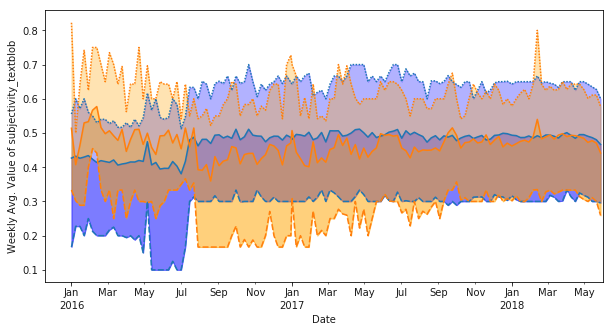

In [22]:
line_plot(x_pd1,"Weekly Avg. Value of subjectivity_textblob")

#### polarity_textblob

In [23]:
from pyspark.sql.functions import avg, expr

metric = "polarity_textblob"

q1 = expr("percentile_approx(" + metric + ", 0.25,100000000)")
q2 = expr('percentile_approx(' + metric + ', 0.75,100000000)')


#.filter("neg_vader != 0 or pos_vader != 0")\
#
x = both_ss\
.filter(metric + " != 0")\
.groupBy("week","Cryptocurrency")\
.agg(
avg(metric).alias("Medium"),
q1.alias("Lower Quartile"),
q2.alias("Upper Quartile"),
)


In [24]:
x_pd = x.sort("week").toPandas()

In [25]:
x_pd1 = pd.melt(x_pd,
        id_vars=["week", "Cryptocurrency"], 
        var_name="Quartile Range", value_name="Weekly Avg. Value of polarity_textblob")

In [26]:
x_pd1 = x_pd1[x_pd1.week > '2015-01']
x_pd1["week"] = pd.to_datetime(x_pd1.week.str[0:4], format='%Y') + \
             pd.to_timedelta(x_pd1.week.str[5:7].astype("int").add(-1).mul(7).astype(str) + ' days')

In [27]:
x_pd1.head()

,week,Cryptocurrency,Quartile Range,Weekly Avg. Value of polarity_textblob
2,2016-01-01,Bitcoin,Medium,0.234397
3,2016-01-01,Ethereum,Medium,0.303846
4,2016-01-08,Bitcoin,Medium,0.245643
5,2016-01-08,Ethereum,Medium,0.051417
6,2016-01-15,Ethereum,Medium,0.173238


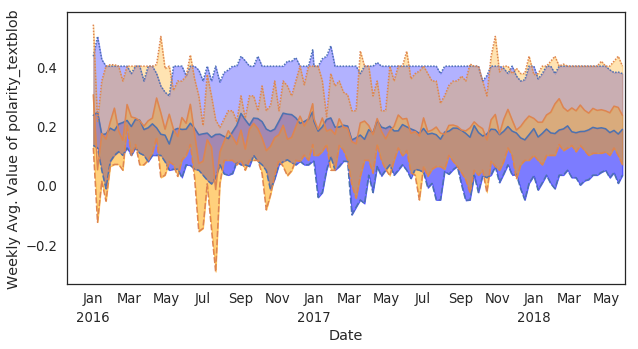

In [28]:
line_plot(x_pd1,"Weekly Avg. Value of polarity_textblob")

#### pos_vader

In [29]:
from pyspark.sql.functions import avg, expr

metric = "pos_vader"

q1 = expr("percentile_approx(" + metric + ", 0.25,100000000)")
q2 = expr('percentile_approx(' + metric + ', 0.75,100000000)')


#.filter("neg_vader != 0 or pos_vader != 0")\
#
x = both_ss\
.filter(metric + " != 0")\
.groupBy("week","Cryptocurrency")\
.agg(
avg(metric).alias("Medium"),
q1.alias("Lower Quartile"),
q2.alias("Upper Quartile"),
)


In [30]:
x_pd = x.sort("week").toPandas()

In [31]:
x_pd1 = pd.melt(x_pd,
        id_vars=["week", "Cryptocurrency"], 
        var_name="Quartile Range", value_name="Weekly Avg. Value of pos_vader")

In [32]:
x_pd1 = x_pd1[x_pd1.week > '2015-01']
x_pd1["week"] = pd.to_datetime(x_pd1.week.str[0:4], format='%Y') + \
             pd.to_timedelta(x_pd1.week.str[5:7].astype("int").add(-1).mul(7).astype(str) + ' days')

In [33]:
x_pd1.head()

,week,Cryptocurrency,Quartile Range,Weekly Avg. Value of pos_vader
2,2016-01-01,Bitcoin,Medium,0.232638
3,2016-01-01,Ethereum,Medium,0.252000
4,2016-01-08,Bitcoin,Medium,0.230067
5,2016-01-08,Ethereum,Medium,0.203797
6,2016-01-15,Ethereum,Medium,0.191732


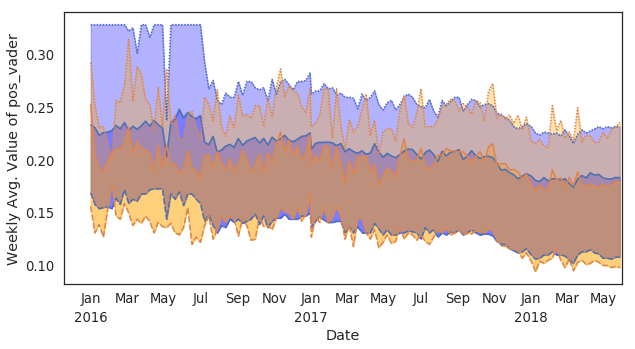

In [34]:
line_plot(x_pd1,"Weekly Avg. Value of pos_vader")

#### neg_vader

In [35]:
from pyspark.sql.functions import avg, expr

metric = "neg_vader"

q1 = expr("percentile_approx(" + metric + ", 0.25,100000000)")
q2 = expr('percentile_approx(' + metric + ', 0.75,100000000)')


#.filter("neg_vader != 0 or pos_vader != 0")\
#
x = both_ss\
.filter(metric + " != 0")\
.groupBy("week","Cryptocurrency")\
.agg(
avg(metric).alias("Medium"),
q1.alias("Lower Quartile"),
q2.alias("Upper Quartile"),
)


In [36]:
x_pd = x.sort("week").toPandas()

In [37]:
x_pd1 = pd.melt(x_pd,
        id_vars=["week", "Cryptocurrency"], 
        var_name="Quartile Range", value_name="Weekly Avg. Value of neg_vader")

In [38]:
x_pd1 = x_pd1[x_pd1.week > '2015-01']
x_pd1["week"] = pd.to_datetime(x_pd1.week.str[0:4], format='%Y') + \
             pd.to_timedelta(x_pd1.week.str[5:7].astype("int").add(-1).mul(7).astype(str) + ' days')

In [39]:
x_pd1.head()

,week,Cryptocurrency,Quartile Range,Weekly Avg. Value of neg_vader
1,2016-01-01,Bitcoin,Medium,0.179125
2,2016-01-01,Ethereum,Medium,0.180875
3,2016-01-08,Bitcoin,Medium,0.182591
4,2016-01-08,Ethereum,Medium,0.162200
5,2016-01-15,Ethereum,Medium,0.185304


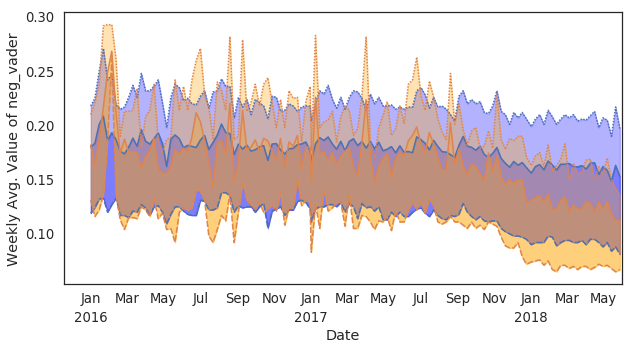

In [40]:
line_plot(x_pd1,"Weekly Avg. Value of neg_vader")

#### compound_vader

In [41]:
from pyspark.sql.functions import avg, expr

metric = "compound_vader"

q1 = expr("percentile_approx(" + metric + ", 0.25,100000000)")
q2 = expr('percentile_approx(' + metric + ', 0.75,100000000)')

#.filter("neg_vader != 0 or pos_vader != 0")\

x = both_ss\
.filter("compound_vader != 0")\
.groupBy("week","Cryptocurrency")\
.agg(
avg(metric).alias("Medium"),
q1.alias("Lower Quartile"),
q2.alias("Upper Quartile"),
)


In [42]:
both_ss.limit(5).toPandas()

,pos_vader,neg_vader,neu_vader,compound_vader,polarity_textblob,subjectivity_textblob,datetime,month,week,Cryptocurrency
0,0.225,0.0,0.775,0.7003,0.375000,0.400000,2018-02-13 21:51:00,2018-02-01,2018-07,Ethereum
1,0.000,0.0,1.000,0.0000,0.268182,0.650000,2018-02-13 21:47:00,2018-02-01,2018-07,Ethereum
2,0.197,0.0,0.803,0.4019,0.500000,0.500000,2018-02-13 21:45:00,2018-02-01,2018-07,Ethereum
3,0.174,0.0,0.826,0.2263,0.166667,0.166667,2018-02-13 21:33:00,2018-02-01,2018-07,Ethereum
4,0.222,0.0,0.778,0.5719,0.800000,1.000000,2018-02-13 20:58:00,2018-02-01,2018-07,Ethereum


In [43]:
x_pd = x.sort("week").toPandas()

In [44]:
x_pd1 = pd.melt(x_pd,
        id_vars=["week", "Cryptocurrency"], 
        var_name="Quartile Range", value_name="Weekly Avg. Value of compound_vader")

In [45]:
x_pd1 = x_pd1[x_pd1.week > '2015-01']
x_pd1["week"] = pd.to_datetime(x_pd1.week.str[0:4], format='%Y') + \
             pd.to_timedelta(x_pd1.week.str[5:7].astype("int").add(-1).mul(7).astype(str) + ' days')

In [46]:
x_pd1.head()

,week,Cryptocurrency,Quartile Range,Weekly Avg. Value of compound_vader
2,2016-01-01,Bitcoin,Medium,0.411097
3,2016-01-01,Ethereum,Medium,0.284081
4,2016-01-08,Bitcoin,Medium,0.371699
5,2016-01-08,Ethereum,Medium,0.308364
6,2016-01-15,Ethereum,Medium,0.291784


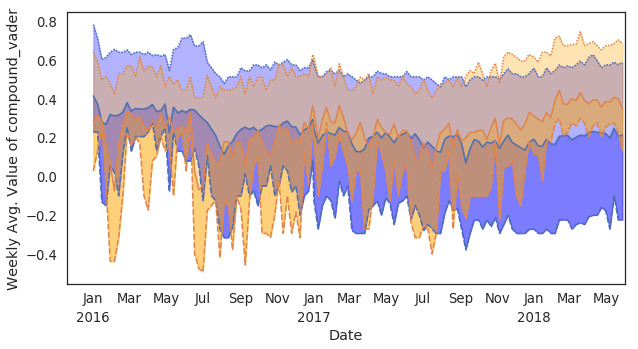

In [47]:
line_plot(x_pd1,"Weekly Avg. Value of compound_vader")

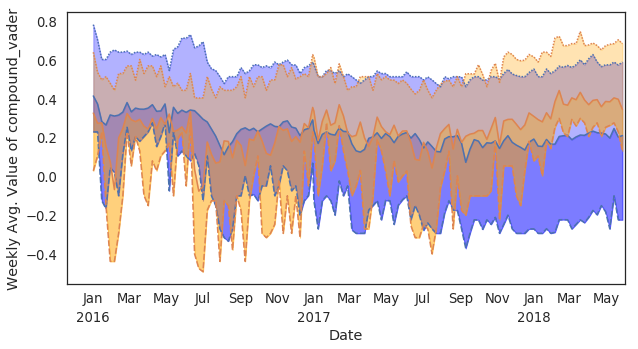

In [454]:
line_plot(x_pd1,"Weekly Avg. Value of compound_vader")

### Violin

In [30]:
ss = both_ss.drop("datetime").filter("month >= '2018-05'").toPandas()

In [31]:
import pandas as pd
ss["month_date"] = pd.to_datetime(ss.month)#.dt.date

In [32]:
ss = ss.sort_values("month")

In [33]:
ss.head()

,pos_vader,neg_vader,neu_vader,compound_vader,polarity_textblob,subjectivity_textblob,month,week,Cryptocurrency,month_date
0,0.0,0.0,1.0,0.0,0.000000,0.000000,2018-05-01,2018-20,Ethereum,2018-05-01
559847,0.0,0.0,1.0,0.0,0.000000,0.000000,2018-05-01,2018-18,Bitcoin,2018-05-01
559848,0.0,0.0,1.0,0.0,0.000000,0.000000,2018-05-01,2018-20,Bitcoin,2018-05-01
559849,0.0,0.0,1.0,0.0,0.000000,0.000000,2018-05-01,2018-20,Bitcoin,2018-05-01
559850,0.0,0.0,1.0,0.0,-0.183333,0.233333,2018-05-01,2018-20,Bitcoin,2018-05-01


In [41]:
ss2 = ss.melt(id_vars=["Cryptocurrency","month_date"],
        value_vars=["pos_vader","neg_vader","neu_vader","compound_vader","polarity_textblob","subjectivity_textblob"],
       value_name="sentiment_score",
              var_name="sentiment_type"
             )

In [42]:
ss2.head()

,Cryptocurrency,month_date,sentiment_type,sentiment_score
0,Ethereum,2018-05-01,pos_vader,0.0
1,Bitcoin,2018-05-01,pos_vader,0.0
2,Bitcoin,2018-05-01,pos_vader,0.0
3,Bitcoin,2018-05-01,pos_vader,0.0
4,Bitcoin,2018-05-01,pos_vader,0.0


In [57]:
# order the dataframe to my licking using a custom sort

sorter = ["compound_vader","pos_vader","neg_vader","neu_vader","polarity_textblob","subjectivity_textblob"]
sorterIndex = dict(zip(sorter,range(len(sorter))))
ss2['Tm_Rank'] = ss2['sentiment_type'].map(sorterIndex)
ss2 = ss2.sort_values(["Cryptocurrency","Tm_Rank"])

/home/jeroen/miniconda3/envs/udacity/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


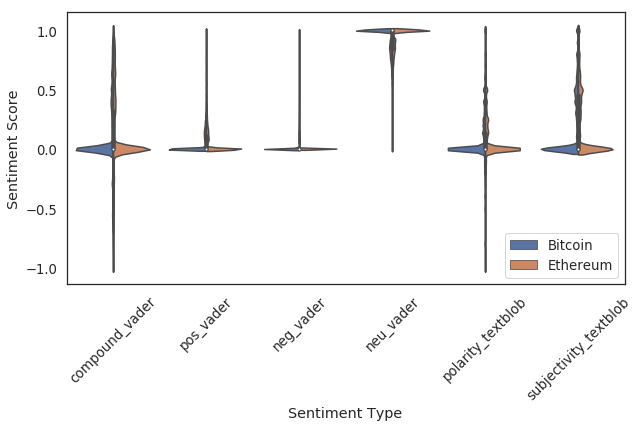

In [58]:
%matplotlib inline
## figure out the date stuff
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

#sns.set(font_scale=1.2)
#sns.set_style("white")

fig, ax = plt.subplots(figsize=(10,5))
ax = sns.violinplot(data=ss2,
                x="sentiment_type",
                y="sentiment_score",
                    hue="Cryptocurrency",
                    split=True
                      )

plt.xticks(rotation=45)
ax.set_xlabel("Sentiment Type")
ax.set_ylabel("Sentiment Score")

ax.legend(loc='lower right')


In [59]:
comp_v_logic = (ss2.sentiment_type == "compound_vader") & (ss2.sentiment_score != 0)
pos_v_logic = (ss2.sentiment_type == "pos_vader") & (ss2.sentiment_score != 0) 
neg_v_logic = (ss2.sentiment_type == "neg_vader") & (ss2.sentiment_score != 0) 
neu_v_logic = (ss2.sentiment_type == "neu_vader") & (ss2.sentiment_score != 1)
pol_tb_logic = (ss2.sentiment_type == "polarity_textblob") & (ss2.sentiment_score != 0)
sub_tb_logic = (ss2.sentiment_type == "subjectivity_textblob") & (ss2.sentiment_score != 0)

logic = (comp_v_logic) | (pos_v_logic) | (neg_v_logic) | (neu_v_logic) | (pol_tb_logic) | (sub_tb_logic)

In [60]:
ss3 = ss2[logic]

/home/jeroen/miniconda3/envs/udacity/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


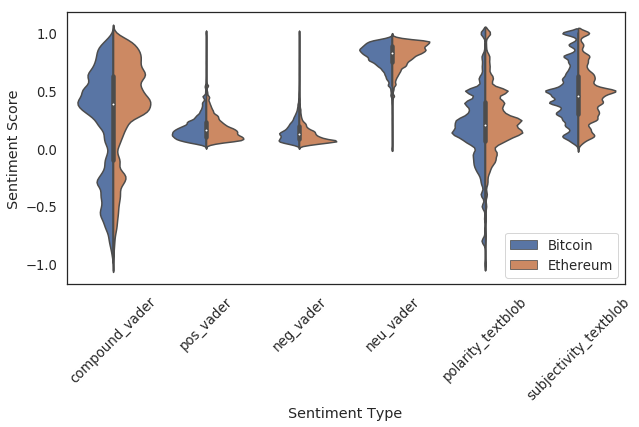

In [61]:
%matplotlib inline
## figure out the date stuff
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

#sns.set(font_scale=1.2)
#sns.set_style("white")

fig, ax = plt.subplots(figsize=(10,5))
ax = sns.violinplot(data=ss3,
                x="sentiment_type",
                y="sentiment_score",
                    hue="Cryptocurrency",
                    split=True
                      )

plt.xticks(rotation=45)
ax.set_xlabel("Sentiment Type")
ax.set_ylabel("Sentiment Score")

ax.legend(loc='lower right')


In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(15,7))
sns.lineplot(x="month_date", y="compound_vader",
             hue="Cryptocurrency",
             data=ss)

In [78]:
ss[(ss.neu_vader != 1)].sort_values("neg_vader",ascending=True).shape

(2283819, 9)

In [ ]:
2757700

In [69]:
ss[((ss.neg_vader == 0) & (ss.pos_vader == 0))].sort_values("pos_vader",ascending=True).shape

(2757922, 9)

In [58]:
ss.shape

(5041519, 9)

In [28]:
ss.dropna(axis=0).shape

(10076270, 9)

In [39]:
ss[((ss.neg_vader != 0) | (ss.pos_vader != 0))].sort_values("neg_vader",ascending=True).shape

(4563633, 9)

In [32]:
(ss.neg_vader != 0).shape

(10078367,)

In [33]:
(ss.pos_vader != 0).shape

(10078367,)

In [36]:
(ss.neg_vader == 0.000).shape

(10078367,)

In [37]:
(ss.pos_vader == 0.000).shape

(10078367,)

In [19]:
ss.head()

,pos_vader,neg_vader,neu_vader,compound_vader,polarity_textblob,subjectivity_textblob,month,coin
0,0.225,0.000,0.775,0.7003,0.375000,0.400000,2018-02-01,eth
1,0.000,0.000,1.000,0.0000,0.268182,0.650000,2018-02-01,eth
2,0.197,0.000,0.803,0.4019,0.500000,0.500000,2018-02-01,eth
3,0.112,0.135,0.753,-0.2732,0.055556,0.263889,2018-02-01,eth
4,0.174,0.000,0.826,0.2263,0.166667,0.166667,2018-02-01,eth


/home/jeroen/miniconda3/envs/udacity/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


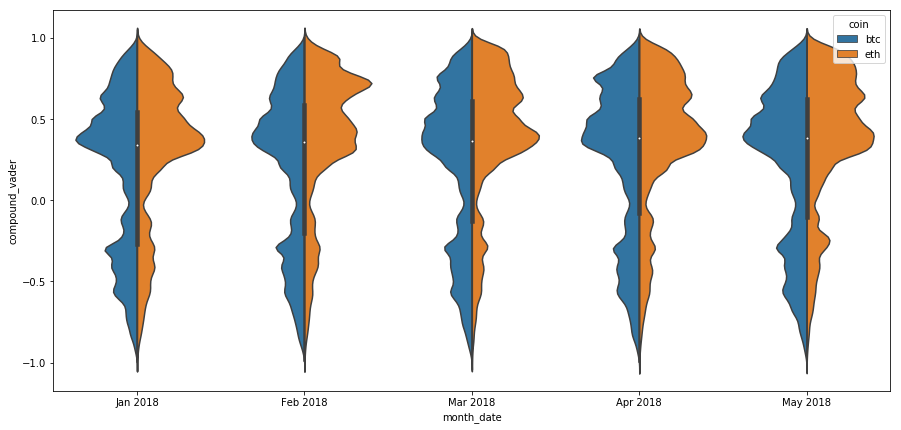

In [21]:
%matplotlib inline
## figure out the date stuff
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
ax = sns.violinplot(data=ss[(ss.neg_vader != 0) | (ss.pos_vader != 0)]\
                    .sort_values("month"),
                x="month_date",
                y="compound_vader",
                    hue="coin",
                    split=True
                      )
#ax.xaxis_date()
#ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(
plt.FixedFormatter(ss.sort_values("month").month_date.dt.strftime("%b %Y").unique())
)

/home/jeroen/miniconda3/envs/udacity/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


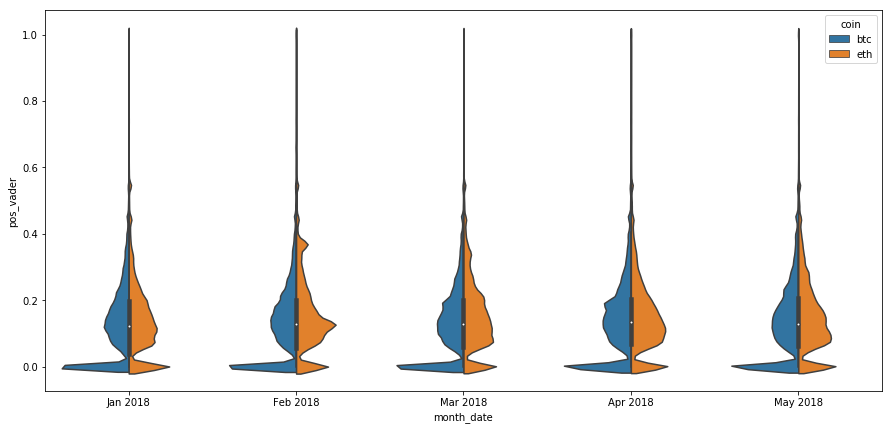

In [40]:
%matplotlib inline
## figure out the date stuff
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
ax = sns.violinplot(data=ss[(ss.neg_vader != 0) | (ss.pos_vader != 0)]\
                    .sort_values("month"),
                x="month_date",
                y="pos_vader",
                    hue="coin",
                    split=True
                      )
#ax.xaxis_date()
#ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(
plt.FixedFormatter(ss.sort_values("month").month_date.dt.strftime("%b %Y").unique())
)

/home/jeroen/miniconda3/envs/udacity/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


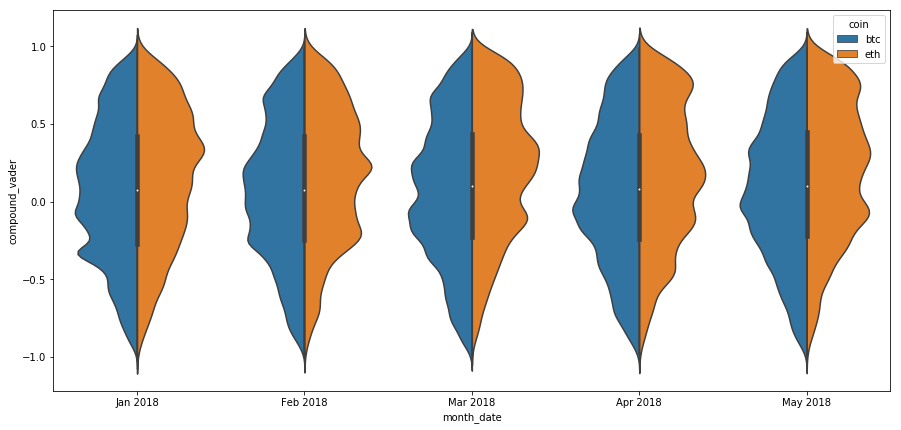

In [41]:
%matplotlib inline
## figure out the date stuff
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
ax = sns.violinplot(data=ss[((ss.neg_vader != 0) & (ss.pos_vader != 0))]\
                    .sort_values("month"),
                x="month_date",
                y="compound_vader",
                    hue="coin",
                    split=True
                      )
#ax.xaxis_date()
#ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(
plt.FixedFormatter(ss.sort_values("month").month_date.dt.strftime("%b %Y").unique())
)

/home/jeroen/miniconda3/envs/udacity/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


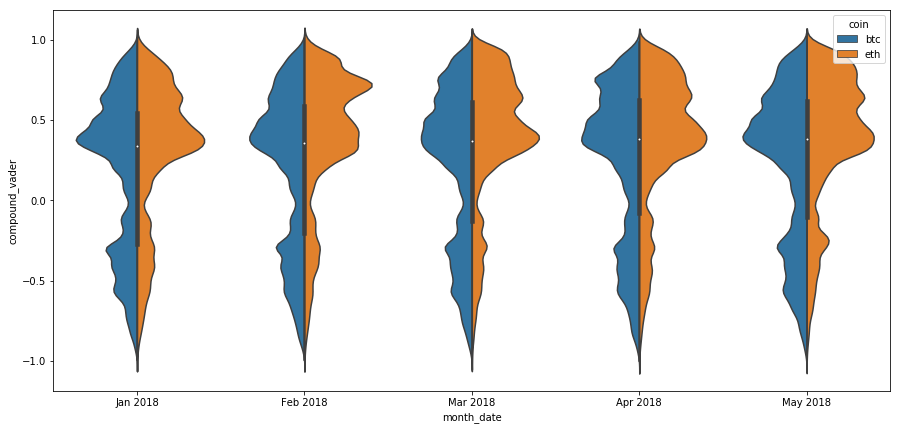

In [36]:
%matplotlib inline
## figure out the date stuff
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
ax = sns.violinplot(data=ss[(ss.neu_vader != 1)]\
                    .sort_values("month"),
                x="month_date",
                y="compound_vader",
                    hue="coin",
                    split=True
                      )
#ax.xaxis_date()
#ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(
plt.FixedFormatter(ss.sort_values("month").month_date.dt.strftime("%b %Y").unique())
)

/home/jeroen/miniconda3/envs/udacity/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


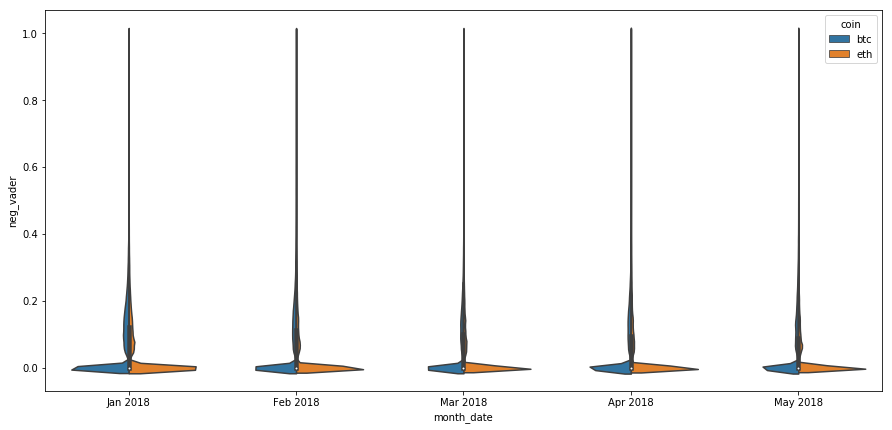

In [39]:
%matplotlib inline
## figure out the date stuff
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
ax = sns.violinplot(data=ss[(ss.neu_vader != 1)]\
                    .sort_values("month"),
                x="month_date",
                y="neg_vader",
                    hue="coin",
                    split=True
                      )
#ax.xaxis_date()
#ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(
plt.FixedFormatter(ss.sort_values("month").month_date.dt.strftime("%b %Y").unique())
)

/home/jeroen/miniconda3/envs/udacity/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


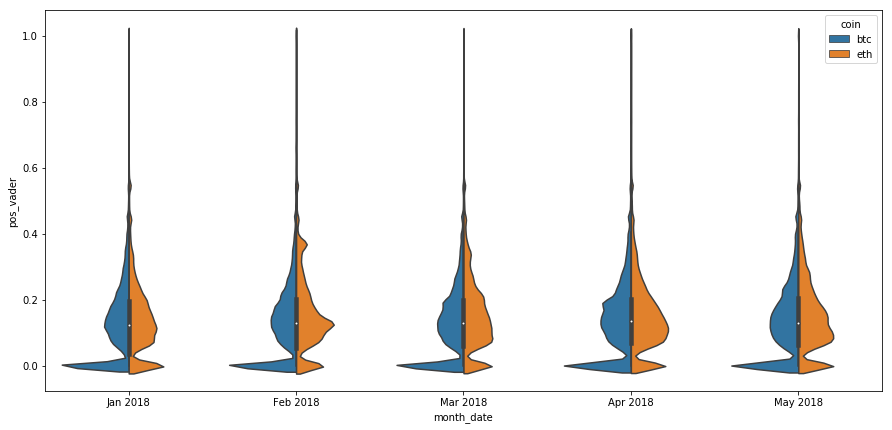

In [40]:
%matplotlib inline
## figure out the date stuff
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
ax = sns.violinplot(data=ss[(ss.neu_vader != 1)]\
                    .sort_values("month"),
                x="month_date",
                y="pos_vader",
                    hue="coin",
                    split=True
                      )
#ax.xaxis_date()
#ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(
plt.FixedFormatter(ss.sort_values("month").month_date.dt.strftime("%b %Y").unique())
)

# Reddit

In [5]:
parquet_reddit_path = "../data/reddit-crypto/parquet/complete_sentiment/"
redd = spark.read.parquet(parquet_reddit_path)

In [6]:
from pyspark.sql.functions import when,col, date_format, concat, lit


In [7]:
when_statment = when(col("subreddit") == "ethtrader","Ethereum")\
                .when(col("subreddit") == "ethereum","Ethereum")\
                .when(col("subreddit") == "Bitcoin","Bitcoin")\
                .when(col("subreddit") == "btc","Bitcoin")

In [8]:
redd\
.filter("created_utc < '2018-06-01'")\
.filter("created_utc > '2015-12-31'")\
.select("created_utc").sort(desc("created_utc")).show(1)

+-------------------+
|        created_utc|
+-------------------+
|2018-05-31 23:59:54|
+-------------------+
only showing top 1 row



In [9]:
redd_ss = redd\
.filter("created_utc < '2018-06-01'")\
.filter("created_utc > '2015-12-31'")\
.select("subreddit","pos_vader","neg_vader","neu_vader","compound_vader","polarity_textblob","subjectivity_textblob","created_utc")\
.withColumnRenamed("created_utc","datetime")\
.withColumn("Cryptocurrency",when_statment)\
.withColumn(
    "month",
    date_format('datetime','yyyy-MM')
)\
.withColumn(
    "week",
    date_format('datetime','yyyy-ww')
)\
.withColumn("month",concat(col("month"),lit("-01")))\

## Investigate strange stuff

In [ ]:
2018-05-07	to the 14th

In [22]:
redd_ss.filter("datetime >= '2018-05-01'")\
.filter("Cryptocurrency == 'Ethereum'")\
.select('week',"pos_vader")\
.filter("pos_vader == 1.0")\
.groupBy('week')\
.count()\
.sort("week")\
.show()

+-------+-----+
|   week|count|
+-------+-----+
|2018-18|  165|
|2018-19|  150|
|2018-20|  161|
|2018-21|  138|
|2018-22|   99|
+-------+-----+



In [42]:
from pyspark.sql.functions import expr,avg
metric = "pos_vader"

q1 = expr("percentile_approx(" + metric + ", 0.25,100000)")
q2 = expr('percentile_approx(' + metric + ', 0.75,100000)')


#.filter("neg_vader != 0 or pos_vader != 0")\
#

redd_ss.filter("datetime >= '2018-05-01'")\
.filter("pos_vader != 0")\
.select('week',"pos_vader","Cryptocurrency")\
.groupBy("week","Cryptocurrency")\
.agg(
avg(metric).alias("Medium"),
q1.alias("Lower Quartile"),
q2.alias("Upper Quartile"),
)\
.sort("week")\
.show()

+-------+--------------+-------------------+--------------+--------------+
|   week|Cryptocurrency|             Medium|Lower Quartile|Upper Quartile|
+-------+--------------+-------------------+--------------+--------------+
|2018-18|       Bitcoin|0.21883329862489861|         0.095|         0.268|
|2018-18|      Ethereum| 0.2512607770140119|         0.116|         0.318|
|2018-19|       Bitcoin|0.22139909434109278|         0.097|         0.275|
|2018-19|      Ethereum| 0.2363593195955265|         0.109|         0.295|
|2018-20|       Bitcoin|0.21715015640970883|         0.094|         0.263|
|2018-20|      Ethereum|0.23819819327100247|         0.109|         0.297|
|2018-21|       Bitcoin|0.21989728919053184|         0.096|         0.271|
|2018-21|      Ethereum|0.23554537952854349|         0.108|         0.294|
|2018-22|       Bitcoin| 0.2207380969444604|         0.095|         0.269|
|2018-22|      Ethereum|0.22532191588543354|         0.101|         0.285|
+-------+--------------+-

## Summary

In [13]:
#redd_ss.summary().toPandas()

,summary,subreddit,pos_vader,neg_vader,neu_vader,compound_vader,polarity_textblob,subjectivity_textblob,Cryptocurrency,month,week
0,count,11552230,11552230,11552230,11552230,11552230,11552230,11552230,11552230,11552230,11552230
1,mean,None,0.12219166393448255,0.0679385267504364,0.809196753652767,0.12077671479485212,0.08593311213911488,0.36678500685082593,None,None,None
2,stddev,None,0.1744652703349708,0.1192459312758539,0.19898741192437067,0.45704581917640413,0.2453651889781949,0.3048213101494431,None,None,None
3,min,Bitcoin,0.0,0.0,0.0,-1.0,-1.0,0.0,Bitcoin,2010-09-01,2010-01
4,25%,None,0.0,0.0,0.72,0.0,0.0,0.0,None,None,None
5,50%,None,0.068,0.0,0.84,0.0,0.0,0.4,None,None,None
6,75%,None,0.175,0.102,1.0,0.4592,0.2,0.585,None,None,None
7,max,ethtrader,1.0,1.0,1.0,1.0,1.0,1.0,Ethereum,2018-03-01,2018-13


## Line plot

In [80]:
%matplotlib inline
def line_plot(df,ycol_name):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates

    years = mdates.YearLocator()   # set yearly ticker 
    months = mdates.MonthLocator(bymonth=None, bymonthday=1, interval=2)  # set monthly ticker 
    yearsFmt = mdates.DateFormatter('\n%Y') # set format for year 
    monthsFmt = mdates.DateFormatter('%b') # set format for month 
  
    
    fig, ax = plt.subplots(figsize=(10,5))
    
    ax = sns.lineplot(data=df,x="week",y=ycol_name,hue="Cryptocurrency",style="Quartile Range")
    #plt.xticks(rotation=90)
    #ax.set_xlim(right="2018-06-01")
    
    ax.xaxis.set_major_locator(years) 
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.set_minor_formatter(monthsFmt)
    ax.set_xlabel("Date")
    #plt.margins(x=0)
    
    #fig.canvas.draw()

    #labels = [label.get_text() for n, label in enumerate(ax.xaxis.get_ticklabels())]
    #print(labels)
    #labels_new = []
#    for label in labels:
#        week = label[-2:]
#        year = label[:4]
#
#        if week != "01":
#            labels_new.append(week)
#        else:
#            new_label = week + "\n" + year
#            labels_new.append(new_label)
#
#    ax.set_xticklabels(labels_new)
#
#    every_nth = 8
#    for n, label in enumerate(ax.xaxis.get_ticklabels()):
#        text = label.get_text()
#        if "01" not in text: 

#            week = int(text[-2:])
#            year = text[:4]

#            if (week % every_nth != 0):
#                label.set_visible(False)

            #if (week == 52):
            #    label.set_visible(False)

    # Get the two lines from the axes to generate shading
    l1 = ax.lines[0]
    l2 = ax.lines[1]
    l3 = ax.lines[2]

    l4 = ax.lines[3]
    l5 = ax.lines[4]
    l6 = ax.lines[5]


    # Get the xy data from the lines so that we can shade
    x1 = l1.get_xydata()[:,0]
    y1 = l1.get_xydata()[:,1]

    x2 = l2.get_xydata()[:,0]
    y2 = l2.get_xydata()[:,1]

    x3 = l3.get_xydata()[:,0]
    y3 = l3.get_xydata()[:,1]

    x4 = l4.get_xydata()[:,0]
    y4 = l4.get_xydata()[:,1]

    x5 = l5.get_xydata()[:,0]
    y5 = l5.get_xydata()[:,1]

    x6 = l6.get_xydata()[:,0]
    y6 = l6.get_xydata()[:,1]

    # fill the lines
    ax.fill_between(x1,y1,y2, color="blue", alpha=0.3)
    ax.fill_between(x1,y2,y3, color="blue", alpha=0.3)

    ax.fill_between(x1,y4,y5, color="orange", alpha=0.3)
    ax.fill_between(x1,y5,y6, color="orange", alpha=0.3)

    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.legend().set_visible(False)
    #ax.legend(ncol=2, loc="lower right", frameon=True)
    sns.set(font_scale=1.2)
    sns.set_style("white")

### subjectivity_textblob

In [89]:
from pyspark.sql.functions import avg, expr, concat

metric = "subjectivity_textblob"

q1 = expr("percentile_approx(" + metric + ", 0.25,100000000)")
q2 = expr('percentile_approx(' + metric + ', 0.75,100000000)')


#.filter("neg_vader != 0 or pos_vader != 0")\
#
x = redd_ss\
.filter(metric + " != 0")\
.groupBy("week","Cryptocurrency")\
.agg(
avg(metric).alias("Medium"),
q1.alias("Lower Quartile"),
q2.alias("Upper Quartile"),
)\
#.withColumn("week",concat(lit("01-"),col("week")))


In [90]:
x_pd = x.sort("week").toPandas()

In [91]:
x_pd1 = pd.melt(x_pd,
        id_vars=["week", "Cryptocurrency"], 
        var_name="Quartile Range", value_name="Weekly Avg. Value of subjectivity_textblob")

In [92]:
x_pd1.head()

,week,Cryptocurrency,Quartile Range,Weekly Avg. Value of subjectivity_textblob
0,2015-01,Bitcoin,Medium,0.526158
1,2015-01,Ethereum,Medium,0.504783
2,2016-01,Bitcoin,Medium,0.523876
3,2016-01,Ethereum,Medium,0.545574
4,2016-02,Bitcoin,Medium,0.525027


In [93]:
x_pd1 = x_pd1[x_pd1.week > '2015-52']
x_pd1["week"] = pd.to_datetime(x_pd1.week.str[0:4], format='%Y') + \
             pd.to_timedelta(x_pd1.week.str[5:7].astype("int").add(-1).mul(7).astype(str) + ' days')


In [94]:
x_pd1.sort_values("week")

,week,Cryptocurrency,Quartile Range,Weekly Avg. Value of subjectivity_textblob
2,2016-01-01,Bitcoin,Medium,0.523876
3,2016-01-01,Ethereum,Medium,0.545574
259,2016-01-01,Ethereum,Lower Quartile,0.411667
258,2016-01-01,Bitcoin,Lower Quartile,0.400000
514,2016-01-01,Bitcoin,Upper Quartile,0.633333
515,2016-01-01,Ethereum,Upper Quartile,0.666667
261,2016-01-08,Ethereum,Lower Quartile,0.395370
260,2016-01-08,Bitcoin,Lower Quartile,0.400000
516,2016-01-08,Bitcoin,Upper Quartile,0.635417
517,2016-01-08,Ethereum,Upper Quartile,0.650000


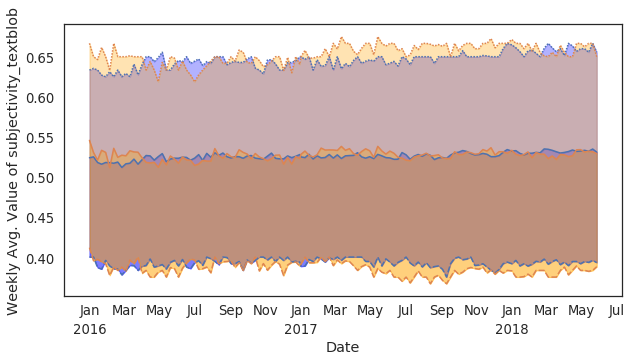

In [95]:
line_plot(x_pd1,"Weekly Avg. Value of subjectivity_textblob")

### polarity_textblob

In [121]:
from pyspark.sql.functions import avg, expr

metric = "polarity_textblob"

q1 = expr("percentile_approx(" + metric + ", 0.25,100000000)")
q2 = expr('percentile_approx(' + metric + ', 0.75,100000000)')


#.filter("neg_vader != 0 or pos_vader != 0")\
#
x = redd_ss\
.filter(metric + " != 0")\
.groupBy("week","Cryptocurrency")\
.agg(
avg(metric).alias("Medium"),
q1.alias("Lower Quartile"),
q2.alias("Upper Quartile"),
)


In [122]:
x_pd = x.sort("week").toPandas()

In [123]:
x_pd1 = pd.melt(x_pd,
        id_vars=["week", "Cryptocurrency"], 
        var_name="Quartile Range", value_name="Weekly Avg. Value of polarity_textblob")

In [124]:
x_pd1 = x_pd1[x_pd1.week > '2015-52']
x_pd1["week"] = pd.to_datetime(x_pd1.week.str[0:4], format='%Y') + \
             pd.to_timedelta(x_pd1.week.str[5:7].astype("int").add(-1).mul(7).astype(str) + ' days')

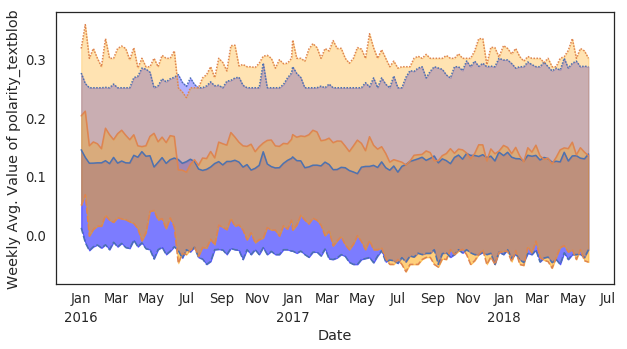

In [125]:
line_plot(x_pd1,"Weekly Avg. Value of polarity_textblob")

### pos_vader

In [126]:
from pyspark.sql.functions import avg, expr

metric = "pos_vader"

q1 = expr("percentile_approx(" + metric + ", 0.25,100000000)")
q2 = expr('percentile_approx(' + metric + ', 0.75,100000000)')


#.filter("neg_vader != 0 or pos_vader != 0")\
#
x = redd_ss\
.filter(metric + " != 0")\
.groupBy("week","Cryptocurrency")\
.agg(
avg(metric).alias("Medium"),
q1.alias("Lower Quartile"),
q2.alias("Upper Quartile"),
)


In [127]:
x_pd = x.sort("week").toPandas()

In [128]:
x_pd1 = pd.melt(x_pd,
        id_vars=["week", "Cryptocurrency"], 
        var_name="Quartile Range", value_name="Weekly Avg. Value of pos_vader")

In [129]:
x_pd1 = x_pd1[x_pd1.week > '2015-52']
x_pd1["week"] = pd.to_datetime(x_pd1.week.str[0:4], format='%Y') + \
             pd.to_timedelta(x_pd1.week.str[5:7].astype("int").add(-1).mul(7).astype(str) + ' days')

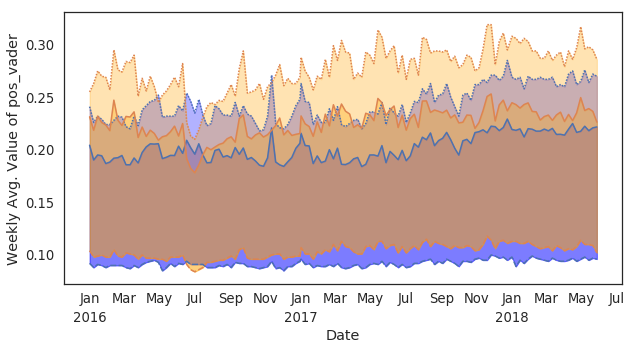

In [130]:
line_plot(x_pd1,"Weekly Avg. Value of pos_vader")

### neg_vader

In [131]:
from pyspark.sql.functions import avg, expr

metric = "neg_vader"

q1 = expr("percentile_approx(" + metric + ", 0.25,100000000)")
q2 = expr('percentile_approx(' + metric + ', 0.75,100000000)')


#.filter("neg_vader != 0 or pos_vader != 0")\
#
x = redd_ss\
.filter(metric + " != 0")\
.groupBy("week","Cryptocurrency")\
.agg(
avg(metric).alias("Medium"),
q1.alias("Lower Quartile"),
q2.alias("Upper Quartile"),
)


In [132]:
x_pd = x.sort("week").toPandas()

In [133]:
x_pd1 = pd.melt(x_pd,
        id_vars=["week", "Cryptocurrency"], 
        var_name="Quartile Range", value_name="Weekly Avg. Value of neg_vader")

In [134]:
x_pd1 = x_pd1[x_pd1.week > '2015-52']
x_pd1["week"] = pd.to_datetime(x_pd1.week.str[0:4], format='%Y') + \
             pd.to_timedelta(x_pd1.week.str[5:7].astype("int").add(-1).mul(7).astype(str) + ' days')

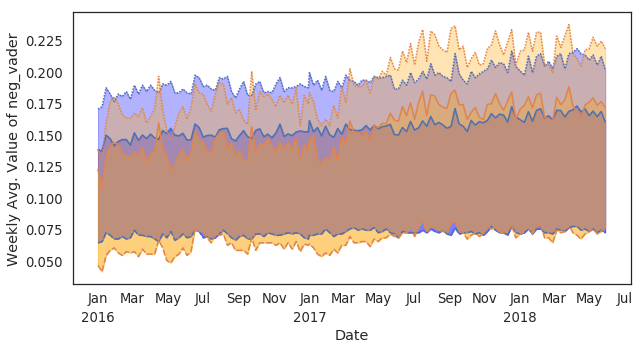

In [135]:
line_plot(x_pd1,"Weekly Avg. Value of neg_vader")

### compound_vader

In [136]:
from pyspark.sql.functions import avg, expr

metric = "compound_vader"

q1 = expr("percentile_approx(" + metric + ", 0.25,100000000)")
q2 = expr('percentile_approx(' + metric + ', 0.75,100000000)')

#.filter("neg_vader != 0 or pos_vader != 0")\

x = redd_ss\
.filter("compound_vader != 0")\
.groupBy("week","Cryptocurrency")\
.agg(
avg(metric).alias("Medium"),
q1.alias("Lower Quartile"),
q2.alias("Upper Quartile"),
)


In [137]:
x_pd = x.sort("week").toPandas()

In [138]:
x_pd1 = pd.melt(x_pd,
        id_vars=["week", "Cryptocurrency"], 
        var_name="Quartile Range", value_name="Weekly Avg. Value of compound_vader")

In [139]:
x_pd1 = x_pd1[x_pd1.week > '2015-52']
x_pd1["week"] = pd.to_datetime(x_pd1.week.str[0:4], format='%Y') + \
             pd.to_timedelta(x_pd1.week.str[5:7].astype("int").add(-1).mul(7).astype(str) + ' days')

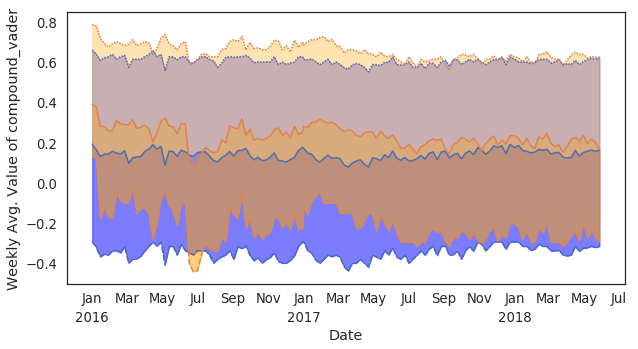

In [140]:
line_plot(x_pd1,"Weekly Avg. Value of compound_vader")

## Violin

In [29]:
redd_ss.sort(desc("datetime")).show()

+---------+---------+---------+---------+--------------+-----------------+---------------------+-------------------+--------------+----------+-------+
|subreddit|pos_vader|neg_vader|neu_vader|compound_vader|polarity_textblob|subjectivity_textblob|           datetime|Cryptocurrency|     month|   week|
+---------+---------+---------+---------+--------------+-----------------+---------------------+-------------------+--------------+----------+-------+
|      btc|      0.0|    0.091|    0.909|        -0.296|              0.0|                  0.5|2018-05-31 23:59:54|       Bitcoin|2018-05-01|2018-22|
|  Bitcoin|    0.055|    0.264|    0.681|       -0.8255|              0.0|                  0.0|2018-05-31 23:59:53|       Bitcoin|2018-05-01|2018-22|
|ethtrader|      0.0|      0.0|      1.0|           0.0|              0.0|                  0.0|2018-05-31 23:59:53|      Ethereum|2018-05-01|2018-22|
|ethtrader|      0.0|      0.0|      1.0|           0.0|             0.25|                 0.2

In [34]:
ss = redd_ss.drop("datetime").filter("month >= '2018-05'").toPandas()

In [35]:
import pandas as pd
ss["month_date"] = pd.to_datetime(ss.month)#.dt.date

In [36]:
ss = ss.sort_values("month")

In [37]:
ss.head()

,subreddit,pos_vader,neg_vader,neu_vader,compound_vader,polarity_textblob,subjectivity_textblob,Cryptocurrency,month,week,month_date
0,btc,0.166,0.184,0.650,0.0139,0.25,0.25,Bitcoin,2018-05-01,2018-21,2018-05-01
176223,Bitcoin,0.688,0.000,0.312,0.2960,0.50,0.50,Bitcoin,2018-05-01,2018-22,2018-05-01
176224,Bitcoin,0.737,0.000,0.263,0.4215,0.60,1.00,Bitcoin,2018-05-01,2018-21,2018-05-01
176225,Bitcoin,1.000,0.000,0.000,0.5267,0.00,0.00,Bitcoin,2018-05-01,2018-21,2018-05-01
176226,Bitcoin,0.000,0.000,1.000,0.0000,0.00,0.00,Bitcoin,2018-05-01,2018-21,2018-05-01


In [38]:
ss2 = ss.melt(id_vars=["Cryptocurrency","month_date"],
        value_vars=["pos_vader","neg_vader","neu_vader","compound_vader","polarity_textblob","subjectivity_textblob"],
       value_name="sentiment_score",
              var_name="sentiment_type"
             )

In [39]:
ss2.head()

,Cryptocurrency,month_date,sentiment_type,sentiment_score
0,Bitcoin,2018-05-01,pos_vader,0.166
1,Bitcoin,2018-05-01,pos_vader,0.688
2,Bitcoin,2018-05-01,pos_vader,0.737
3,Bitcoin,2018-05-01,pos_vader,1.000
4,Bitcoin,2018-05-01,pos_vader,0.000


In [40]:
# order the dataframe to my licking using a custom sort

sorter = ["compound_vader","pos_vader","neg_vader","neu_vader","polarity_textblob","subjectivity_textblob"]
sorterIndex = dict(zip(sorter,range(len(sorter))))
ss2['Tm_Rank'] = ss2['sentiment_type'].map(sorterIndex)
ss2 = ss2.sort_values(["Cryptocurrency","Tm_Rank"])

/home/jeroen/miniconda3/envs/udacity/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


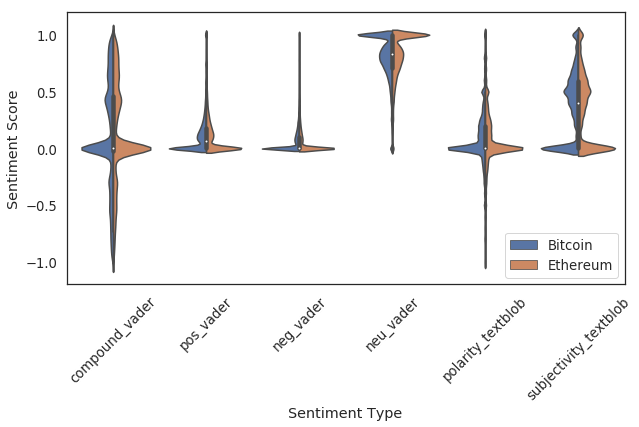

In [41]:
%matplotlib inline
## figure out the date stuff
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

#sns.set(font_scale=1.2)
#sns.set_style("white")

fig, ax = plt.subplots(figsize=(10,5))
ax = sns.violinplot(data=ss2,
                x="sentiment_type",
                y="sentiment_score",
                    hue="Cryptocurrency",
                    split=True
                      )

plt.xticks(rotation=45)
ax.set_xlabel("Sentiment Type")
ax.set_ylabel("Sentiment Score")

ax.legend(loc='lower right')


In [42]:
comp_v_logic = (ss2.sentiment_type == "compound_vader") & (ss2.sentiment_score != 0)
pos_v_logic = (ss2.sentiment_type == "pos_vader") & (ss2.sentiment_score != 0) 
neg_v_logic = (ss2.sentiment_type == "neg_vader") & (ss2.sentiment_score != 0) 
neu_v_logic = (ss2.sentiment_type == "neu_vader") & (ss2.sentiment_score != 1)
pol_tb_logic = (ss2.sentiment_type == "polarity_textblob") & (ss2.sentiment_score != 0)
sub_tb_logic = (ss2.sentiment_type == "subjectivity_textblob") & (ss2.sentiment_score != 0)

logic = (comp_v_logic) | (pos_v_logic) | (neg_v_logic) | (neu_v_logic) | (pol_tb_logic) | (sub_tb_logic)

In [43]:
ss3 = ss2[logic]

/home/jeroen/miniconda3/envs/udacity/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


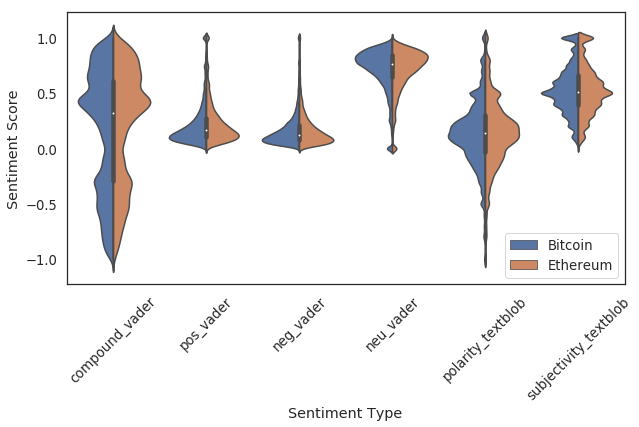

In [44]:
%matplotlib inline
## figure out the date stuff
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

#sns.set(font_scale=1.2)
#sns.set_style("white")

fig, ax = plt.subplots(figsize=(10,5))
ax = sns.violinplot(data=ss3,
                x="sentiment_type",
                y="sentiment_score",
                    hue="Cryptocurrency",
                    split=True
                      )

plt.xticks(rotation=45)
ax.set_xlabel("Sentiment Type")
ax.set_ylabel("Sentiment Score")

ax.legend(loc='lower right')


## old stuff

In [8]:
redd.printSchema()

root
 |-- body: string (nullable = true)
 |-- score_hidden: boolean (nullable = true)
 |-- archived: boolean (nullable = true)
 |-- name: string (nullable = true)
 |-- author: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- downs: integer (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- score: integer (nullable = true)
 |-- retrieved_on: timestamp (nullable = true)
 |-- controversiality: integer (nullable = true)
 |-- gilded: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- ups: integer (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- pos_vader: float (nullable = true)
 |-- neg_vader: float (nullable = true)
 |-- neu_vader: float (nullable = true)
 |-- compound_vader: float (nullable = 

In [134]:
from pyspark.sql.functions import col,date_format,avg, col


redd_daily_sentiment_avg = redd.withColumn('date',date_format('created_utc','yyyy-MM-dd'))\
.groupby('date')\
.agg(
avg("pos_vader"),
avg("neg_vader"),
avg("neu_vader"),
avg("compound_vader"),
avg("polarity_textblob"),
avg("subjectivity_textblob"),
count(when(col("compound_vader") > 0.5, col("compound_vader"))).alias("negative"),
count(when(col("compound_vader") < -0.5, col("compound_vader"))).alias("positive"),
)\
.withColumn(
            "month",
            date_format('date','yyyy-MM')
            )\
.withColumn(
            "pos/neg ratio",
            col("positive")/col("negative")
            )\
.drop("negative","positive")

In [135]:
redd_daility_sentiments = redd_daily_sentiment_avg.withColumn(
                            "month",
                            date_format('date','yyyy-MM')
                                )\
                        .filter("month > '2017-10'")\
                        .withColumn("month",col("month").cast("string"))\
                        .toPandas()

http://brenda.moon.net.au/2012/10/18/pandas-timeseries-plot-setting-x-axis-major-and-minor-ticks-and-labels/

/home/jeroens/miniconda3/envs/pyspark/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<IPython.core.display.Javascript object>


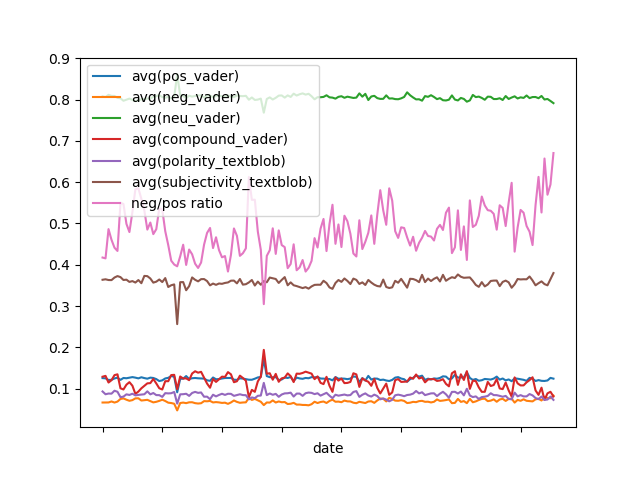

In [170]:
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

xtick_locator = AutoDateLocator()
xtick_formatter = AutoDateFormatter(xtick_locator)

ax = plt.axes()
ax.xaxis.set_major_locator(xtick_locator)
ax.xaxis.set_major_formatter(xtick_formatter)


redd_daility_sentiments.sort_values("date").set_index("date").plot(kind="line")



#x= plt.xticks(redd_daility_sentiments.sort_values("date").index, redd_daility_sentiments.sort_values("date").date, rotation=90)

<IPython.core.display.Javascript object>


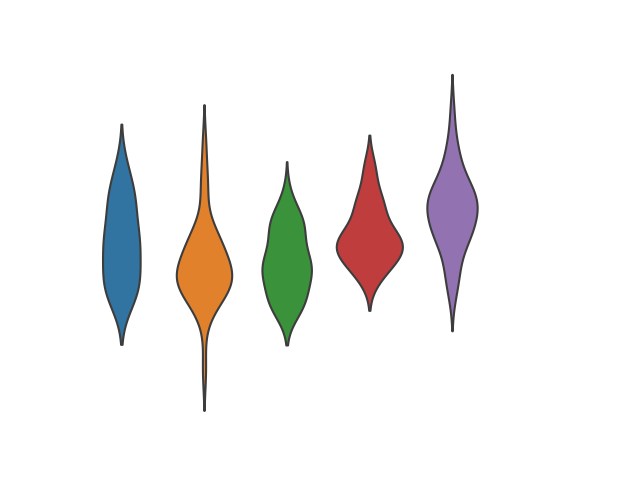

In [154]:
%matplotlib notebook
sns.violinplot(data=redd_daility_sentiments.sort_values("month"),
                x="month",
                y="neg/pos ratio",
                      )

In [141]:
redd_daility_sentiments.dtypes

date                           object
avg(pos_vader)                float64
avg(neg_vader)                float64
avg(neu_vader)                float64
avg(compound_vader)           float64
avg(polarity_textblob)        float64
avg(subjectivity_textblob)    float64
month                          object
neg/pos ratio                 float64
dtype: object